# Identificador de Objetos (Con Imágenes)

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os

In [2]:
training_path = 'img/train'
test_path = 'img/test'

### Utils

In [3]:
# both ORB and SIFT use this
# taken from https://docs.opencv.org/3.4/dc/dc3/tutorial_py_matcher.html

def find_best_match(des1, des2, norm_type = cv2.NORM_L2):
    bf = cv2.BFMatcher(norm_type)
    matches = bf.knnMatch(des1, des2, k=2)
    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append([m])
    return len(good)

def augment_data(img_path, output_path):

    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            
    # Apply augmentation techniques to create new images
    flipped_img = cv2.flip(img, 1)
    cv2.imwrite(f'{output_path}/flipped_img.png', flipped_img)

    rotated_img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    cv2.imwrite(f'{output_path}/rotated_img.png', rotated_img)

    gaussian_blur_img = cv2.GaussianBlur(img, (5,5), 0)
    cv2.imwrite(f'{output_path}/gaussian_blur_img.png', gaussian_blur_img)

    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY )
    cv2.imwrite(f'{output_path}/gray_img.png', gray_img)

    color_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV )
    cv2.imwrite(f'{output_path}/color_img.png', color_img)
    
    height, width, channels = img.shape
    third_width = width // 3
    third_height = height // 3

    for i in range(3):
        for j in range(3):
            patch_img = img[i * third_height:(i + 1) * third_height, j * third_width:(j + 1) * third_width]
            cv2.imwrite(f'{output_path}/patch_{i}_{j}.png', patch_img)

### SIFT

In [4]:
sift_images = ['img/train/aal/original.png', 'img/train/op/original.png', 'img/train/tomats/original.png']

sift = cv2.SIFT_create()
sift_features = []

In [5]:
for img_path in sift_images:
    
    print(img_path)

    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kp, des = sift.detectAndCompute(gray, None)
    
    #img = cv2.drawKeypoints(gray, kp, img)
    sift_features.append(des)


img/train/aal/original.png


img/train/op/original.png
img/train/tomats/original.png


In [6]:
def detect_and_classify_sift(img, thresh = 5):

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kp, des = sift.detectAndCompute(gray, None)
    
    best_match = 0
    best_match_index = -1

    for i in range(len(sift_features)):
        match = find_best_match(des, sift_features[i])
        if match > best_match and match > thresh:
            best_match = match
            best_match_index = i + 1
    
    return best_match_index

### ORB

In [7]:
# taken from: https://docs.opencv.org/3.4/d1/d89/tutorial_py_orb.html

orb_images = ['img/train/aal/original.png', 'img/train/op/original.png', 'img/train/tomats/original.png']

orb = cv2.ORB_create()
orb_features = []

In [8]:
for img_path in orb_images:
    
    print(img_path)

    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kp, des = orb.detectAndCompute(gray, None)
    
    #img = cv2.drawKeypoints(gray, kp, img)
    orb_features.append(des)

img/train/aal/original.png
img/train/op/original.png
img/train/tomats/original.png


In [9]:
def detect_and_classify_orb(img, thresh = 5):

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kp, des = orb.detectAndCompute(gray, None)
    
    best_match = 0
    best_match_index = 0

    for i in range(len(orb_features)):
        match = find_best_match(des, orb_features[i], cv2.NORM_HAMMING)
        if match > best_match and match > thresh:
            best_match = match
            best_match_index = i + 1
    
    return best_match_index

### HOG (+ SVM)

In [10]:
# heavily based on https://machinelearningmastery.com/opencv_hog/

win_size = (64, 128)
block_size = (32, 32)
block_stride = (16, 16)
cell_size = (16, 16)
nbins = 9    

X = []
y = []

Preprocessing

In [11]:
hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)

img_paths = ['img/train/aal', 'img/train/op', 'img/train/tomats']

for img_path in img_paths:
    augment_data(f'{img_path}/original.png', img_path)

for img in os.listdir('img/train/negative'):
    img = cv2.imread(f'img/train/negative/{img}', cv2.IMREAD_COLOR)
    img_resized = cv2.resize(img, win_size)
    h = hog.compute(img_resized)
    X.append(h)
    y.append(0)

for i, img_path in enumerate(img_paths):
    for img in os.listdir(img_path):
        img = cv2.imread(f'{img_path}/{img}', cv2.IMREAD_COLOR)
        img_resized = cv2.resize(img, win_size)
        h = hog.compute(img_resized)
        X.append(h)
        y.append(i + 1)

In [12]:
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.int32)

svm = cv2.ml.SVM_create()
svm.setType(cv2.ml.SVM_C_SVC)
svm.setKernel(cv2.ml.SVM_RBF)
svm.setTermCriteria((cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS,
                     100000,
                     1e-8))
 
svm.train(X, cv2.ml.ROW_SAMPLE, y)
 
# Save the SVM model
svm.save('svm_model_final.yml')
print(svm.getSupportVectors())

[[0.30832908 0.10929369 0.09917963 ... 0.00156427 0.00168084 0.09958997]
 [0.11454679 0.05535133 0.0835734  ... 0.1314652  0.10057634 0.233483  ]
 [0.23864007 0.17382458 0.14200193 ... 0.11057956 0.23029299 0.23029299]
 ...
 [0.07907519 0.06404716 0.08176377 ... 0.12038671 0.14476754 0.22093181]
 [0.13656996 0.13841312 0.17299223 ... 0.18164654 0.12606315 0.11458209]
 [0.25850365 0.17629683 0.12331934 ... 0.00853477 0.03092355 0.1663316 ]]


In [13]:
def detect_and_classify_hog_auto(img):

    svm = cv2.ml.SVM_load('svm_model_final.yml')

    hog.setSVMDetector(svm.getSupportVectors()[0])
 
    locations, scores = hog.detectMultiScale(img)
    x, y, w, h = locations[np.argmax(scores.flatten())]
    window = img[y:y+h, x:x+w]
    window = cv2.resize(window, win_size)

    features = hog.compute(window).flatten()
    pred = svm.predict(features.reshape(1, -1))[1][0][0]
    
    return int(pred)

def detect_and_classify_hog(img):

    svm = cv2.ml.SVM_load('svm_model_final.yml')

    #hog.setSVMDetector(svm.getSupportVectors()[0])
 
    window = img
    window = cv2.resize(window, win_size)

    features = hog.compute(window).flatten()
    pred = svm.predict(features.reshape(1, -1))[1][0][0]
    
    return int(pred)

### Test

In [14]:
#test_img = cv2.imread('img/test/test_0.jpg')
test_img = cv2.imread('img/train/tomats/original.png')

cv2.imshow('test_img', test_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

print(f'SIFT: {detect_and_classify_sift(test_img)}')
print(f'ORB: {detect_and_classify_orb(test_img)}')
print(f'HOG: {detect_and_classify_hog(test_img)}')

SIFT: 3
ORB: 3
HOG: 3


In [15]:
def plot_images_with_class_overlay(imgs, classifications, classifier_name):

    colors = ['red', 'green', 'blue']
    num_images = len(imgs)
    cols = 6
    rows = num_images // cols + (num_images % cols > 0)

    fig, axes = plt.subplots(rows, cols, figsize=(14, 12))

    for i, ax in enumerate(axes.flat):
        if i < num_images:

            ax.imshow(cv2.cvtColor(imgs[i], cv2.COLOR_BGR2RGB))
            ax.axis('off')

            if classifications[i] > 0:
                ax.axhspan(0, imgs[i].shape[0], color=colors[classifications[i] - 1], alpha=0.3)
        else:
            ax.axis('off')

    legend_labels = ['All about love', 'One piece', 'El viejo y la mar']
    legend_patches = [plt.Rectangle((0, 0), 1, 1, color=colors[i], alpha=0.3) for i in range(len(legend_labels))]
    #plt.legend(legend_patches, legend_labels, loc='upper right')
    
    ax_legend = fig.add_subplot(111, frameon=False)
    ax_legend.axis('off')
    ax_legend.legend(legend_patches, legend_labels, loc='upper right')
    
    plt.suptitle(f'{classifier_name} - Class Overlay', fontsize=16)
    plt.tight_layout()
    plt.show()

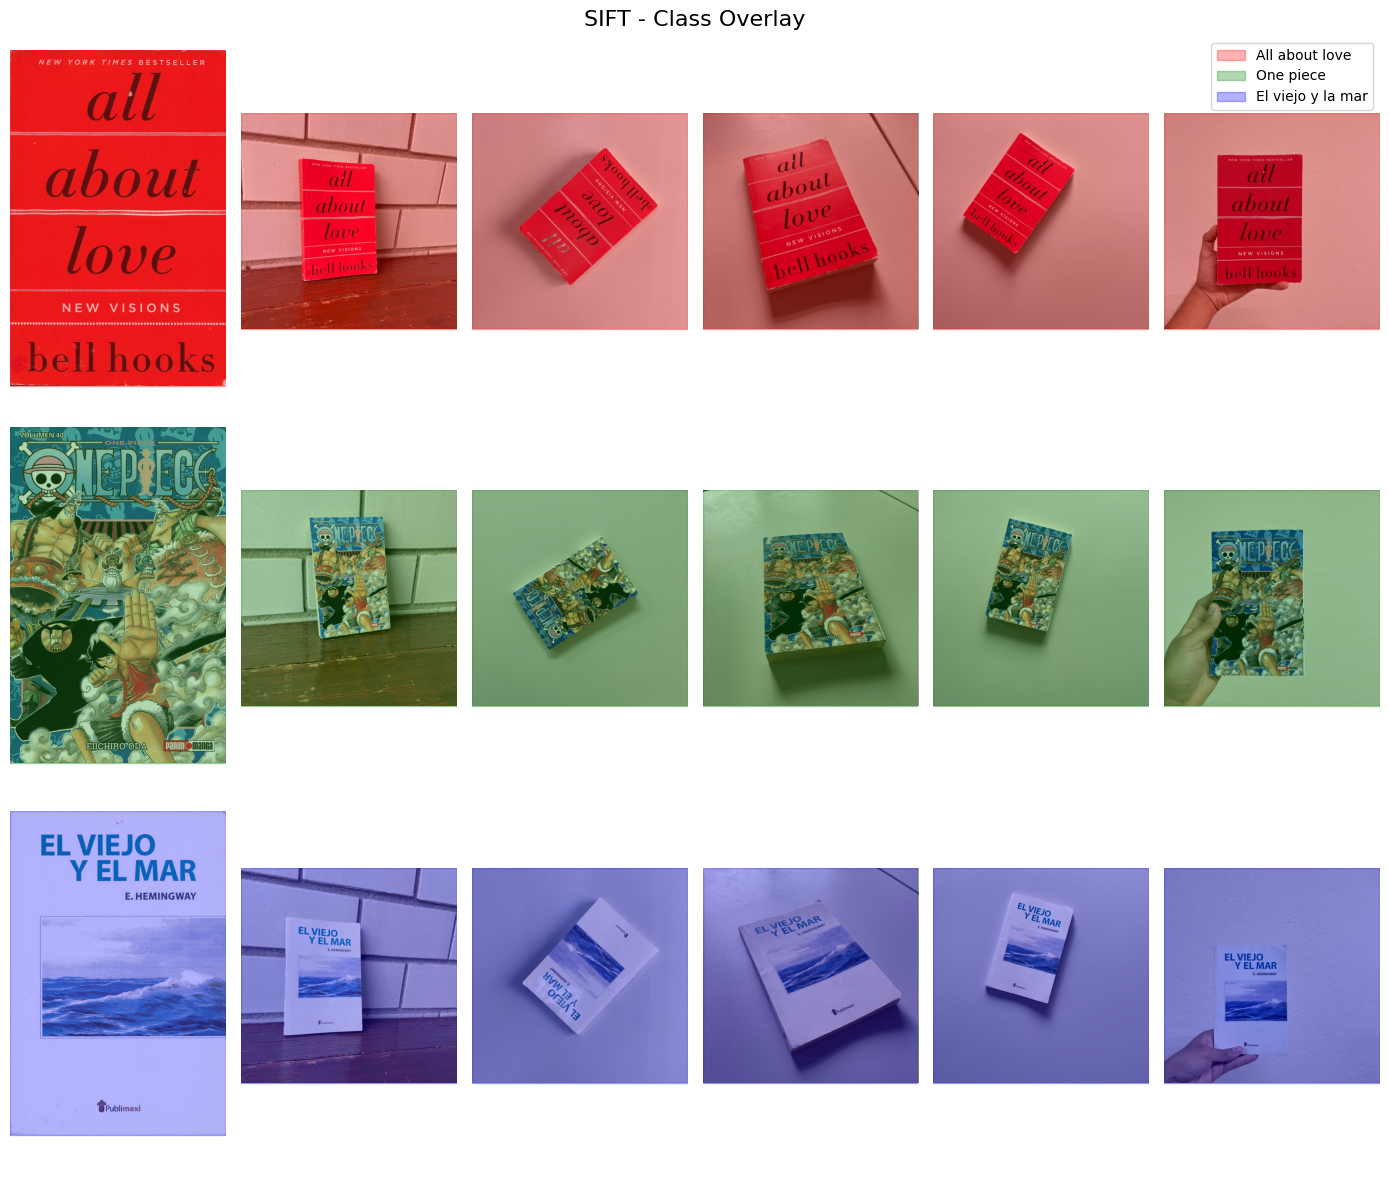

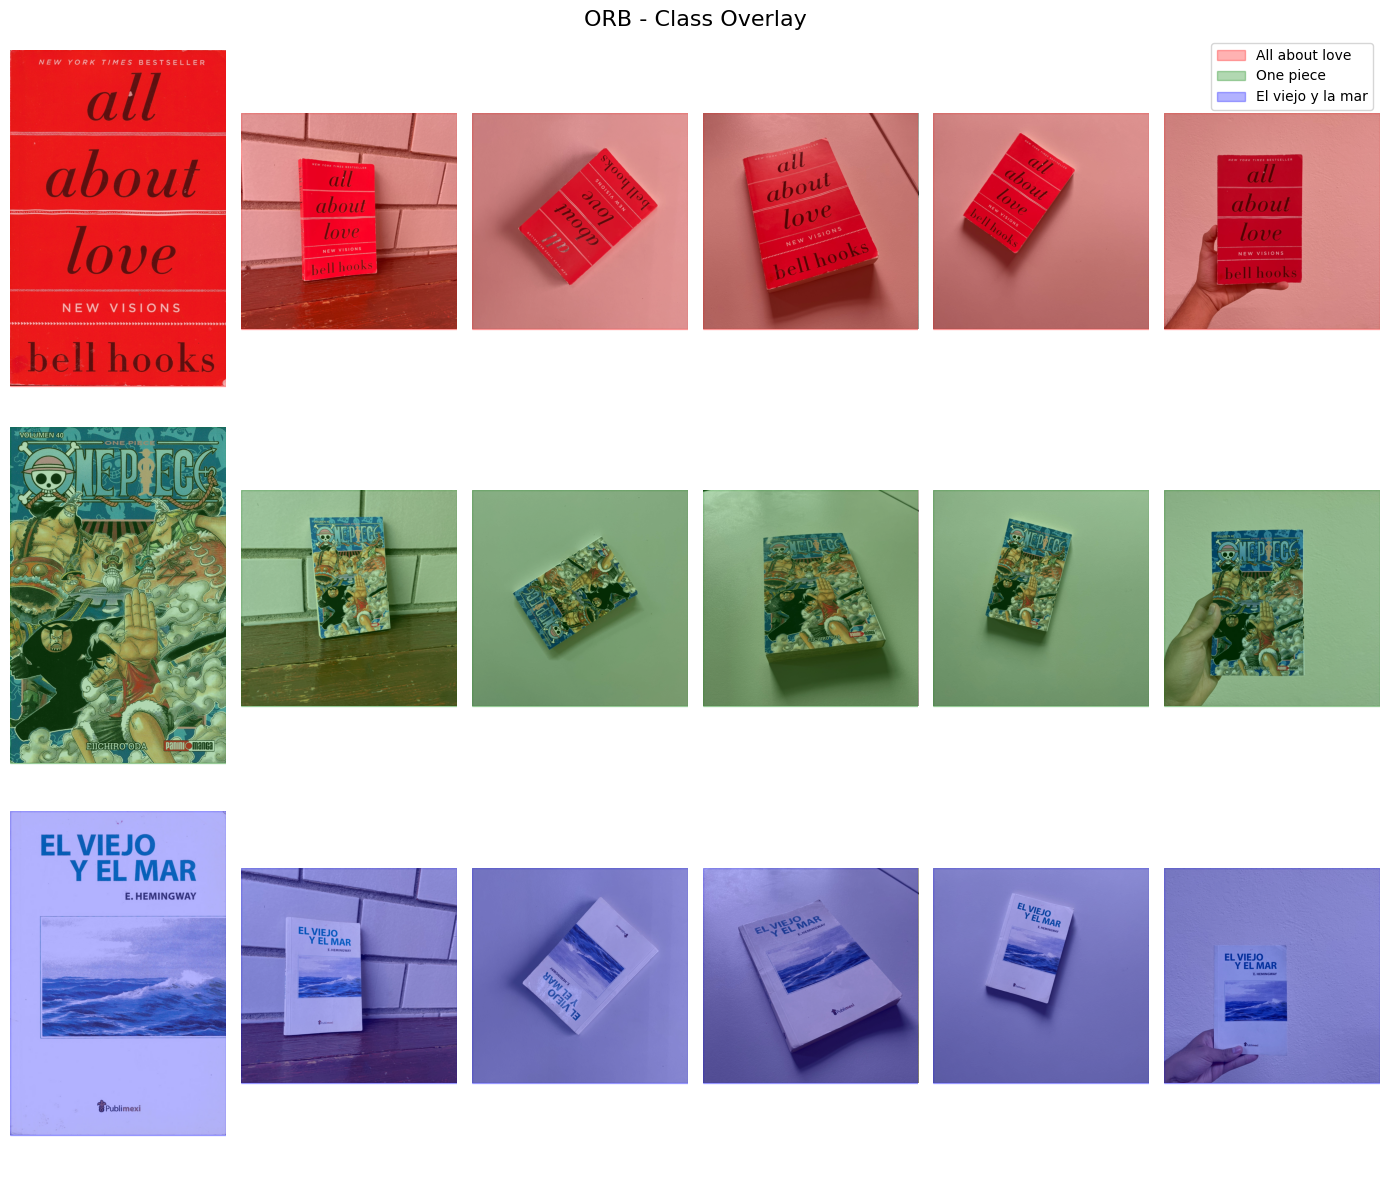

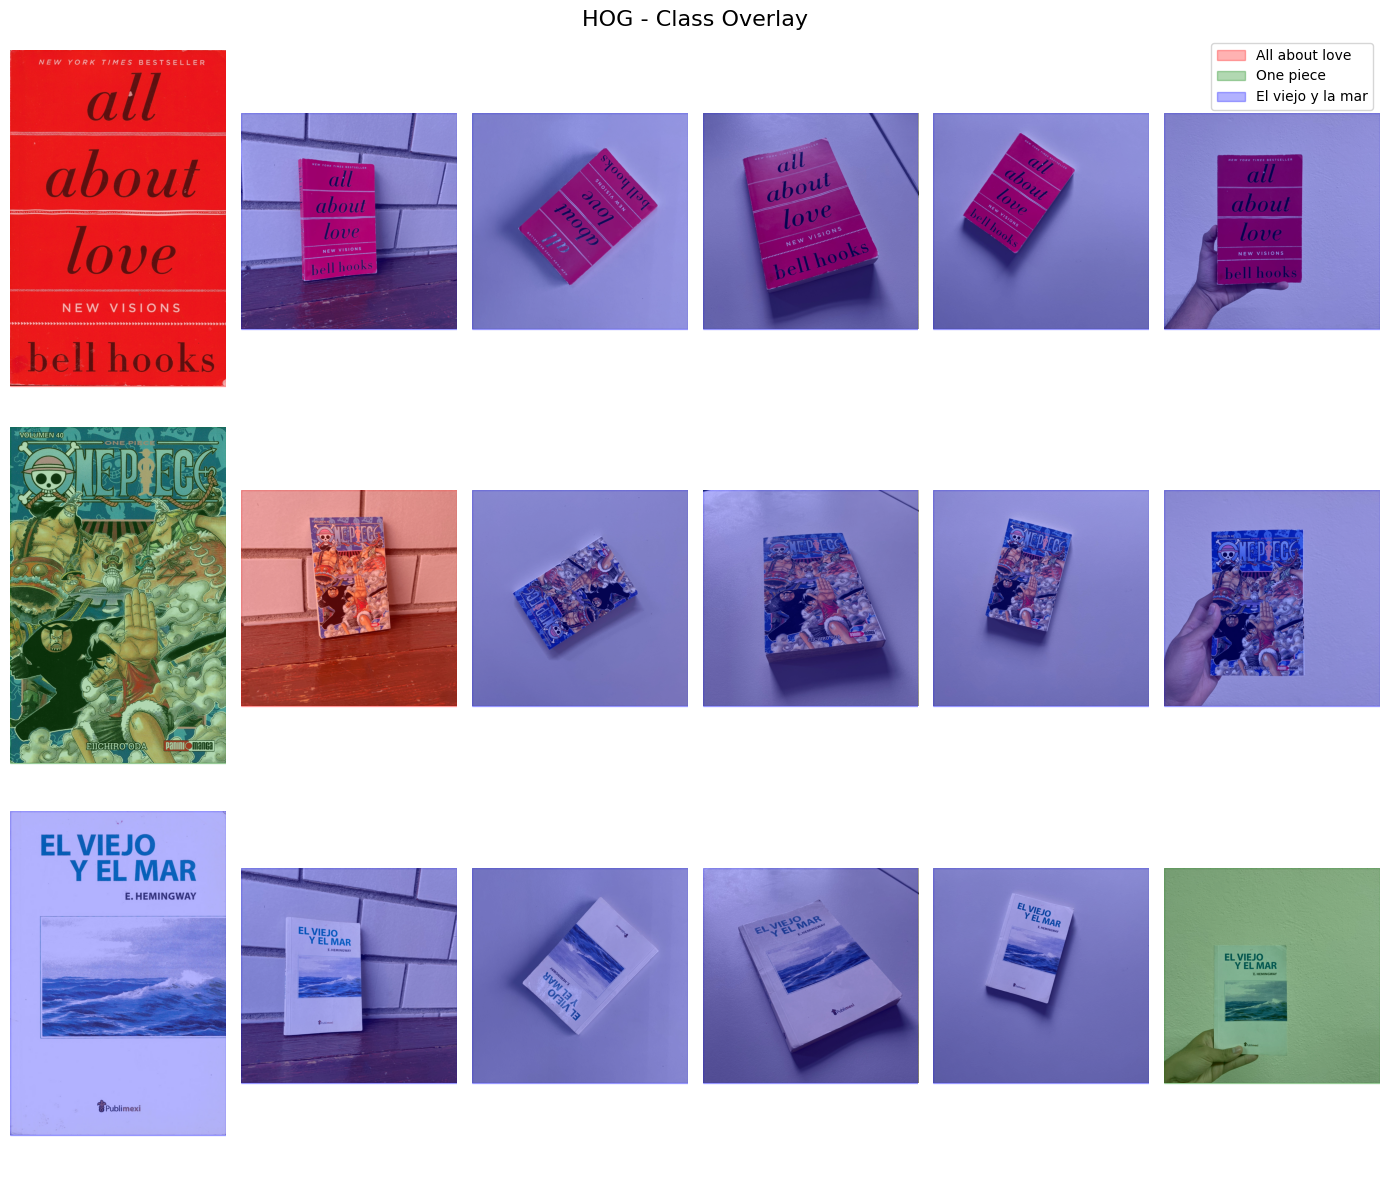

In [16]:
class1_path = 'img/test/aal'
class2_path = 'img/test/op'
class3_path = 'img/test/tomats'

class1_paths = [f'{class1_path}/{img}' for img in os.listdir(class1_path)]
class2_paths = [f'{class2_path}/{img}' for img in os.listdir(class2_path)]
class3_paths = [f'{class3_path}/{img}' for img in os.listdir(class3_path)]

class1_paths.sort()
class2_paths.sort()
class3_paths.sort()

class1_paths.insert(0, 'img/train/aal/original.png')
class2_paths.insert(0, 'img/train/op/original.png')
class3_paths.insert(0, 'img/train/tomats/original.png')

class1_imgs = [cv2.imread(img) for img in class1_paths]
class2_imgs = [cv2.imread(img) for img in class2_paths]
class3_imgs = [cv2.imread(img) for img in class3_paths]

classifications_sift = []
classifications_orb = []
classifications_hog = []

for img in class1_imgs:
    classifications_sift.append(detect_and_classify_sift(img))
    classifications_orb.append(detect_and_classify_orb(img))
    classifications_hog.append(detect_and_classify_hog(img))

for img in class2_imgs:
    classifications_sift.append(detect_and_classify_sift(img))
    classifications_orb.append(detect_and_classify_orb(img))
    classifications_hog.append(detect_and_classify_hog(img))

for img in class3_imgs:
    classifications_sift.append(detect_and_classify_sift(img))
    classifications_orb.append(detect_and_classify_orb(img))
    classifications_hog.append(detect_and_classify_hog(img))

imgs = class1_imgs + class2_imgs + class3_imgs

plot_images_with_class_overlay(imgs, classifications_sift, 'SIFT')
plot_images_with_class_overlay(imgs, classifications_orb, 'ORB')
plot_images_with_class_overlay(imgs, classifications_hog, 'HOG')

In [17]:
class1_imgs[1].shape

(1600, 1600, 3)